In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

base_model_name = "HuggingFaceTB/SmolLM2-360M"
chat_model_name = "HuggingFaceTB/SmolLM2-360M-Instruct"
noah_model_name = "checkpoint_dir/checkpoint-1165"

model_kwargs = dict(
    use_cache=False,
    trust_remote_code=True,
     torch_dtype=torch.bfloat16,
   device_map='auto'
)

base_model = AutoModelForCausalLM.from_pretrained(base_model_name, **model_kwargs)
chat_model = AutoModelForCausalLM.from_pretrained(chat_model_name, **model_kwargs)
noah_model = AutoModelForCausalLM.from_pretrained(noah_model_name, **model_kwargs)

In [2]:

def calculate_weight_diff(base_weight, chat_weight):
    return torch.abs(base_weight - chat_weight).mean().item()

def calculate_layer_diffs(base_model, chat_model):
    layer_diffs = []
    for base_layer, chat_layer in zip(base_model.model.layers, chat_model.model.layers):
        layer_diff = {
            'input_layernorm': calculate_weight_diff(base_layer.input_layernorm.weight, chat_layer.input_layernorm.weight),
            # 'mlp_down_proj': calculate_weight_diff(base_layer.mlp.down_proj.weight, chat_layer.mlp.down_proj.weight),
            # 'mlp_gate_proj': calculate_weight_diff(base_layer.mlp.gate_proj.weight, chat_layer.mlp.gate_proj.weight),
            # 'mlp_up_proj': calculate_weight_diff(base_layer.mlp.up_proj.weight, chat_layer.mlp.up_proj.weight),
            'post_attention_layernorm': calculate_weight_diff(base_layer.post_attention_layernorm.weight, chat_layer.post_attention_layernorm.weight),
            'self_attn_q_proj': calculate_weight_diff(base_layer.self_attn.q_proj.weight, chat_layer.self_attn.q_proj.weight),
            'self_attn_k_proj': calculate_weight_diff(base_layer.self_attn.k_proj.weight, chat_layer.self_attn.k_proj.weight),
            'self_attn_v_proj': calculate_weight_diff(base_layer.self_attn.v_proj.weight, chat_layer.self_attn.v_proj.weight),
            'self_attn_o_proj': calculate_weight_diff(base_layer.self_attn.o_proj.weight, chat_layer.self_attn.o_proj.weight)
        }
        layer_diffs.append(layer_diff)
    return layer_diffs

def visualize_layer_diffs(layer_diffs):
    num_layers = len(layer_diffs)
    num_components = len(layer_diffs[0])
    
    fig, axs = plt.subplots(1, num_components, figsize=(24, 8))
    fig.suptitle(f"{base_model_name} <> {chat_model_name}", fontsize=16)
    
    for i, component in enumerate(layer_diffs[0].keys()):
        component_diffs = [[layer_diff[component]] for layer_diff in layer_diffs]
        sns.heatmap(component_diffs, annot=True, fmt=".6f", cmap="YlGnBu", ax=axs[i], cbar_kws={"shrink": 0.8})
        axs[i].set_title(component)
        axs[i].set_xlabel("Layer")
        axs[i].set_ylabel("Difference")
        axs[i].set_xticks([])
        axs[i].set_yticks(range(num_layers))
        axs[i].set_yticklabels(range(num_layers))
        axs[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()


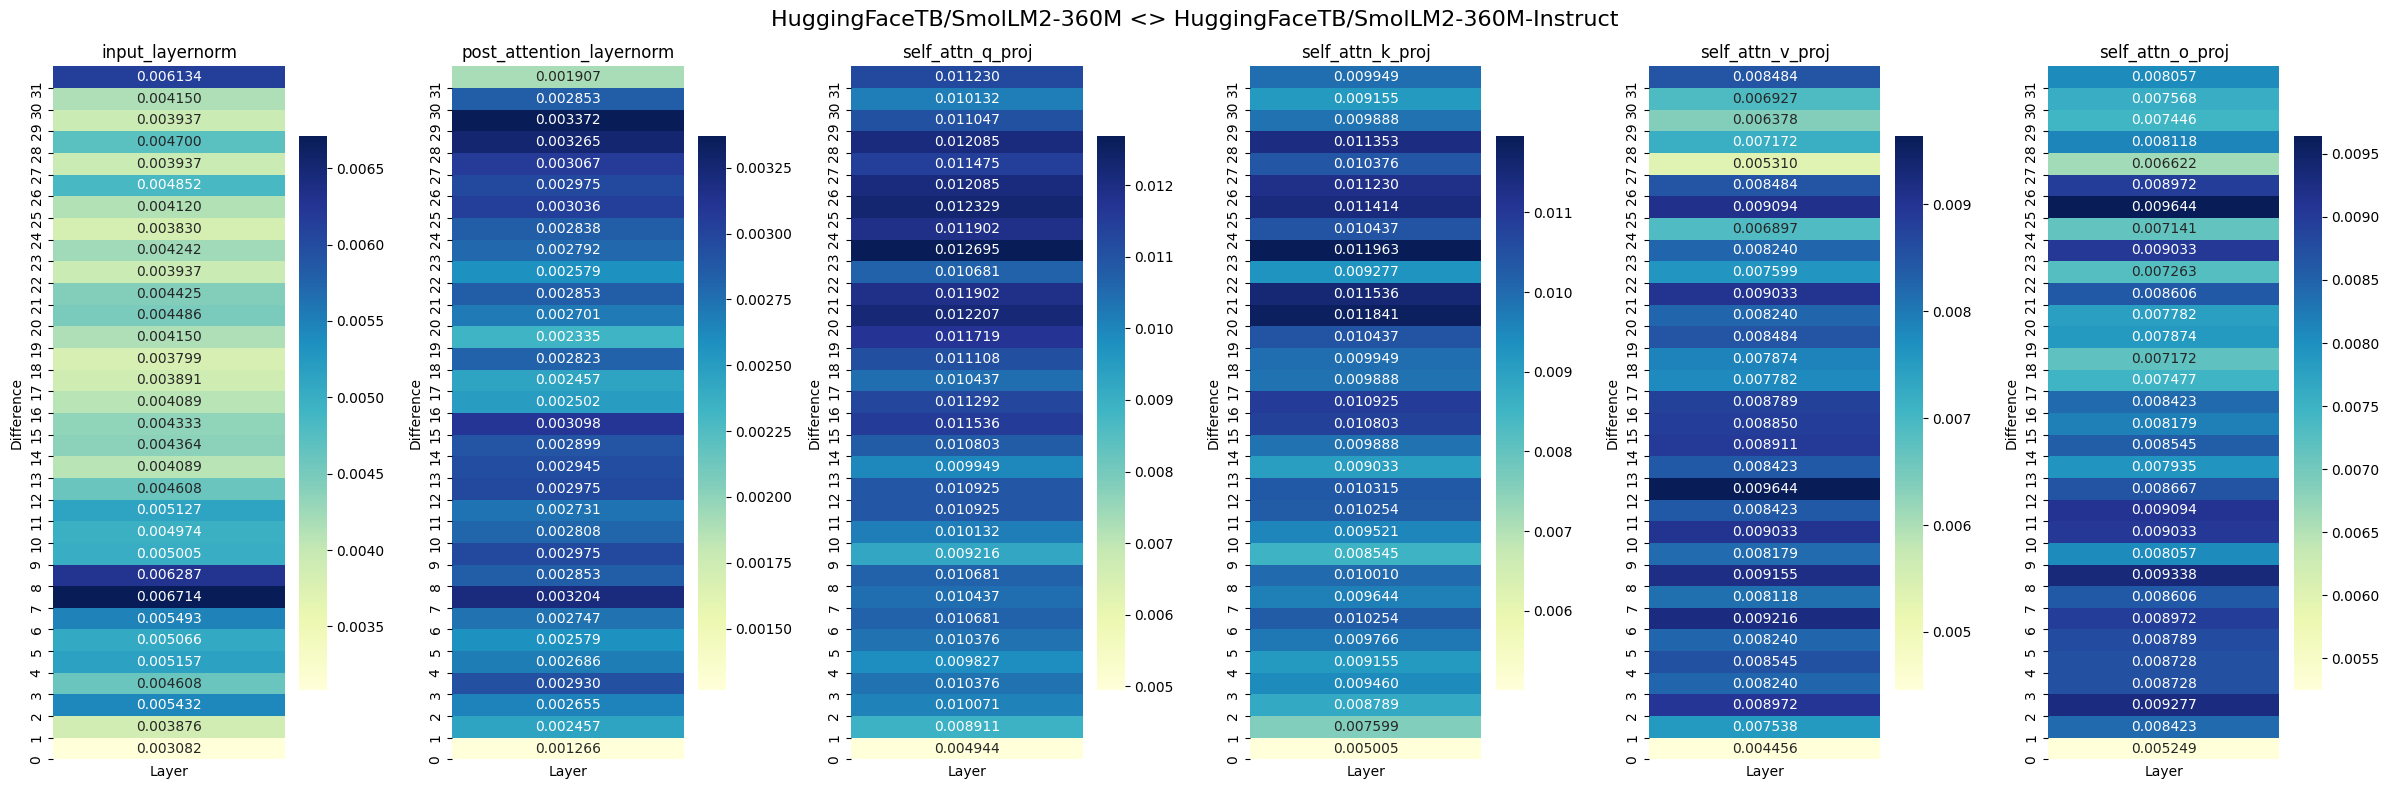

In [3]:

layer_diffs = calculate_layer_diffs(base_model, chat_model)

visualize_layer_diffs(layer_diffs)


In [ ]:

layer_diffs = calculate_layer_diffs(noah_model, chat_model)

visualize_layer_diffs(layer_diffs)


In [4]:
def remove_residuals(base_model, chat_model):

    for base_param, chat_param in zip(base_model.parameters(), chat_model.parameters()):
        residual = chat_param - base_param
        chat_param.data -= residual 

    return chat_model

chat_model_base_again = remove_residuals(base_model, chat_model)

def get_residuals(base_model, chat_model, final_model):
    """
    For every parameter in this model, calculate the residual between base_model and chat_model. 
    Add that residual value to final_model.
    """

    for base_param, chat_param, final_param in zip(base_model.parameters(), chat_model.parameters(), final_model.parameters()):
        residual = chat_param - base_param
        final_param.data += residual

    return final_model

final_model = get_residuals(base_model, chat_model, noah_model)

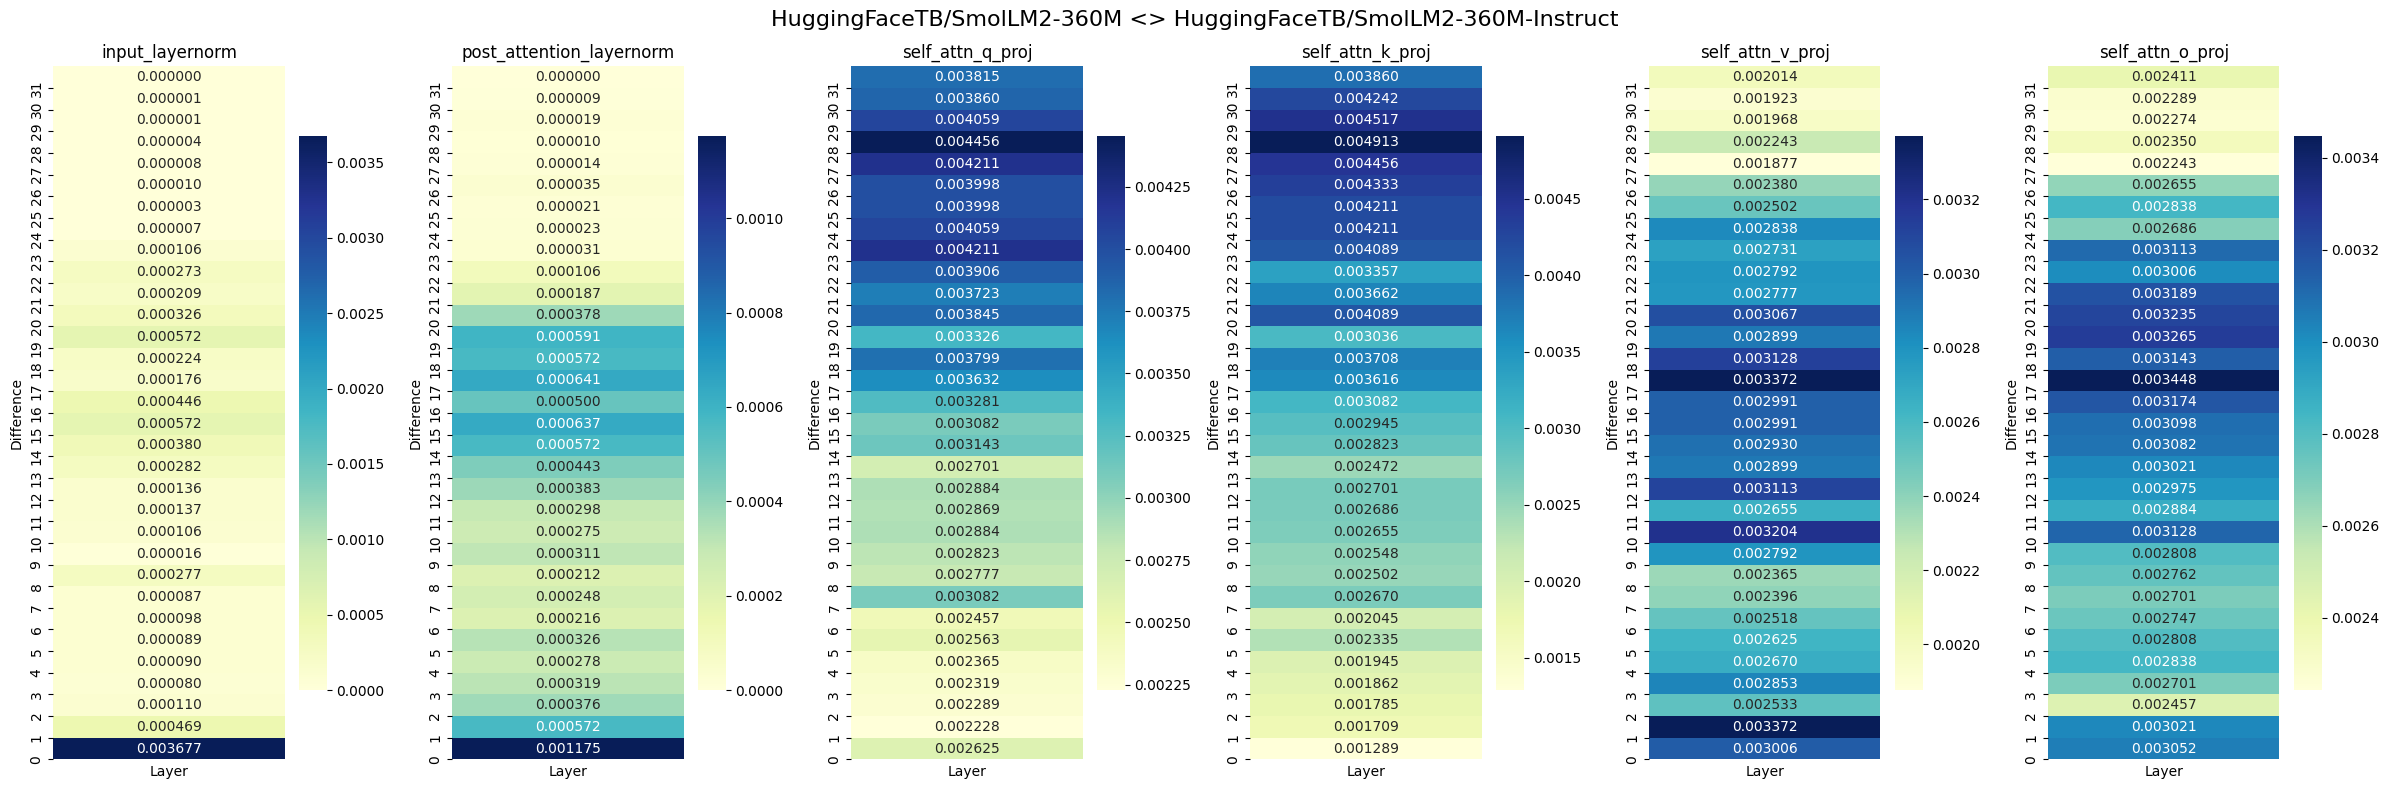

In [5]:
layer_diffs = calculate_layer_diffs(base_model, final_model)

visualize_layer_diffs(layer_diffs)


In [6]:
checkpoint_path = "HuggingFaceTB/SmolLM2-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
tokenizer.model_max_length = 2048
tokenizer.pad_token = "<|endoftext|>"  # note this is specific to smollm
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token )
tokenizer.padding_side = 'right'


In [27]:
model = final_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
prompt = "What is the square root of 169?"

#prompt = "Who is your favorite star trek captain?"
prompt = f"{system_prompt}<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=512,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:3]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>system
You are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>
<|im_start|>user
What is the square root of 169?<|im_end|>
<|im_start|>assistant
The square root of 169 is 13.<|im_end|>


In [26]:
chat_model = AutoModelForCausalLM.from_pretrained(chat_model_name, **model_kwargs)

model = chat_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
prompt = "What is the square root of 169?"

#prompt = "What should I do if I'm on a hike and I see a snake?"
#prompt = "Who is your favorite star trek captain?"

prompt = f"{system_prompt}<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=512,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:3]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>system
You are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>
<|im_start|>user
What is the square root of 169?<|im_end|>
<|im_start|>assistant
The square root of 169 is 13.<|im_end|>


In [25]:
model = noah_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
prompt = "What is the square root of 169?"
#prompt = "Who is your favorite star trek captain?"
prompt = f"{system_prompt}<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=512,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:3]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>system
You are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>
<|im_start|>user
What is the square root of 169?<|im_end|>
<|im_start|>assistant
The square root of 169 is 13.<|im_end|>
